<a href="https://colab.research.google.com/github/Kmaralla/AgentGPT/blob/main/pyairbyte_notebooks/PyAirbyte_Basic_Features_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyAirbyte Demo

Below is a pre-release demo of PyAirbyte.


## Install PyAirbyte


In [ ]:
# Add virtual environment support for running in Google Colab
!apt-get install -qq python3.10-venv

# Install PyAirbyte
%pip install --quiet airbyte

## Locating your Data Source

To see what data sources are available, you can check [our docs](https://docs.airbyte.com/using-airbyte/airbyte-lib/getting-started) or run the following:


In [2]:
# Import PyAirbyte
import airbyte as ab

# Show all available connectors
ab.get_available_connectors()

Thank you for using PyAirbyte!
Anonymous usage reporting is currently enabled. For more information, please see https://docs.airbyte.com/telemetry
{"type":"LOG","log":{"level":"INFO","message":"Docker was not detected. Returning only Python and Manifest-only connectors."}}


['destination-astra',
 'destination-aws-datalake',
 'destination-chroma',
 'destination-convex',
 'destination-duckdb',
 'destination-firebolt',
 'destination-firestore',
 'destination-google-sheets',
 'destination-milvus',
 'destination-motherduck',
 'destination-pgvector',
 'destination-pinecone',
 'destination-qdrant',
 'destination-rabbitmq',
 'destination-sftp-json',
 'destination-snowflake-cortex',
 'destination-sqlite',
 'destination-timeplus',
 'destination-typesense',
 'destination-vectara',
 'destination-weaviate',
 'source-7shifts',
 'source-activecampaign',
 'source-adjust',
 'source-agilecrm',
 'source-aha',
 'source-airbyte',
 'source-aircall',
 'source-airtable',
 'source-akeneo',
 'source-algolia',
 'source-alpha-vantage',
 'source-amazon-ads',
 'source-amazon-seller-partner',
 'source-amazon-sqs',
 'source-amplitude',
 'source-apify-dataset',
 'source-appcues',
 'source-appfigures',
 'source-appfollow',
 'source-apple-search-ads',
 'source-appsflyer',
 'source-apptivo'

## Load the Source Data using PyAirbyte


Create and install a source connector:


In [3]:
import airbyte as ab

# Create and install the source:
source: ab.Source = ab.get_source("source-xero")

Installing 'source-xero' into virtual environment '/content/.venv-source-xero'.
Running 'pip install airbyte-source-xero'...

Connector 'source-xero' installed successfully!
For more information, see the source-xero documentation:
https://docs.airbyte.com/integrations/sources/xero#reference

Writing PyAirbyte logs to file: /tmp/airbyte/logs/2024-12-24/airbyte-log-JFWM683AK.log
Writing `source-xero` logs to file: /tmp/airbyte/logs/source-xero/source-xero-log-JFWM683CJ.log


In [24]:
# Configure the source
source.set_config(
    config={
        "credentials": {
            "auth_type": "oauth2_confidential_application",
            "client_id": "0307ED7C4AE3451485C4A3B8AEF52C8D",
            "client_secret": "0Sz-uIX9vOl32nloIBR8a1j1_bX6G0Z56YBDfP6tETPRTElK"
        },
        "tenant_id": "your_tenant_id_here",
        "start_date": "2023-01-01T00:00:00Z",  # Adjust this date to get more historical data
        "page_size": 100,  # Add this to get more records per request
        # Add report configurations
        "report_types": [
            "ProfitAndLoss",
            "BalanceSheet"
        ],
        # Optional: Specify report parameters
        "report_params": {
            "date_from": "2022-03-01",
            "date_to": "2024-12-31",
            "periods": 12,  # Number of periods to compare
            "timeframe": "MONTH"  # MONTH, QUARTER, or YEAR
        }
    }
)

# Available streams
streams_to_sync = [
    "invoices",
    "accounts",
    "bank_transactions",
    "bank_transfers",
    "contacts",
    "credit_notes",
    "manual_journals",
    "overpayments",
    "payments",
    "prepayments",
    "tracking_categories"
]
source.check()
source.select_streams(streams_to_sync)
read_result: ab.ReadResult = source.read()


#     config={
#         "credentials": {
#             "auth_type": "oauth2_confidential_application",  # or "oauth2_access_token" if using access token
#             "client_id": "0307ED7C4AE3451485C4A3B8AEF52C8D",
#             "client_secret": "0Sz-uIX9vOl32nloIBR8a1j1_bX6G0Z56YBDfP6tETPRTElK"
#         },
#         "tenant_id": "your_tenant_id_here",
#         "start_date": "2022-03-01T00:00:00Z"
#     }
# )

# Verify the config and creds by running `check`:


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-24-6488a8dfd334>, line 11)

## Read Data from the PyAirbyte Cache

Once data is read, we can do anything we want to with the resulting streams. This includes `to_pandas()` which registers a Pandas dataframe and `to_sql_table()` which gives us a SQLAlchemy `Table` boject, which we can use to run SQL queries.


In [21]:
# Select all of the source's streams and read data into the internal cache:

# Set up streams to sync
streams_to_sync = [
    "bank_transactions",
    "bank_transfers",
    "credit_notes",
    "invoices",
    "manual_journals",
    "overpayments",
    "payments",
    "prepayments",
    #"profit_and_loss",
    #"balance_sheet",
    #"purchases",
    #"quotes",
    #"receipts",
    #"reports",
    #"journals",
    #"expense_claims",
    #"bills",
    "purchase_orders",
    #"sales_orders"
]

# Configure the sync to use these streams
source.select_streams(streams_to_sync)
read_result: ab.ReadResult = source.read()

------------------------------------------------

### Sync Progress: `source-xero -> DuckDBCache`

**Started reading from source at `16:02:59`:**

- Read **1** records over **3.8 seconds** (0.3 records/s, 0.00 MB/s).

- Received records for 1 streams:
  - 1 invoices

- Cached **1** records into 1 local cache file(s).

- Finished reading from source at `16:03:09`.

**Started cache processing at `16:03:09`:**

- Processed **1** cache file(s) over **1.39 seconds**.

- Completed cache processing for 1 streams:
  - invoices

- Finished cache processing at `16:03:11`.






**Sync completed at `16:03:11`. Total time elapsed: 12 seconds**

------------------------------------------------


In [10]:
# Display or transform the loaded data
products_df = read_result["accounts"].to_pandas()
display(products_df)

,code,name,type,updateddateutc,reportingcodename,systemaccount,bankaccounttype,taxtype,description,class,...,bankaccountnumber,status,showinexpenseclaims,currencycode,reportingcode,enablepaymentstoaccount,hasattachments,_airbyte_raw_id,_airbyte_extracted_at,_airbyte_meta
0,090,Business Bank Account,BANK,2024-12-23,Asset,None,BANK,NONE,None,ASSET,...,0908007006543,ACTIVE,False,USD,ASS,False,False,0676ad9c-1e0b-730b-8000-7a7a06f23a9d,2024-12-24 15:56:49.869,{}
1,091,Business Savings Account,BANK,2024-12-23,Asset,None,BANK,NONE,None,ASSET,...,121314121314,ACTIVE,False,USD,ASS,False,False,0676ad9c-1e1a-76d4-8000-0bfbcb74e470,2024-12-24 15:56:49.880,{}
2,200,Sales,REVENUE,2024-12-23,Sale of goods,,NONE,OUTPUT,Income from any normal business activity,REVENUE,...,None,ACTIVE,False,None,REV.TRA.GOO,False,False,0676ad9c-1e31-7252-8000-7b2c24528a85,2024-12-24 15:56:49.886,{}
3,260,Other Revenue,REVENUE,2024-12-23,Other Revenue,,,OUTPUT,Any other income that does not relate to norma...,REVENUE,...,None,ACTIVE,False,None,REV.OTH,False,False,0676ad9c-1e46-7765-8000-8c17e5486208,2024-12-24 15:56:49.891,{}
4,270,Interest Income,REVENUE,2024-12-23,Interest,,,NONE,Interest income,REVENUE,...,None,ACTIVE,False,None,REV.INV.INT,False,False,0676ad9c-1e5a-7c73-8000-92df604f71e0,2024-12-24 15:56:49.896,{}
5,300,Purchases,DIRECTCOSTS,2024-12-23,Expense,None,,INPUT,Goods purchased with the intention of selling ...,EXPENSE,...,None,ACTIVE,False,None,EXP,False,False,0676ad9c-1e6e-7c56-8000-464647121d62,2024-12-24 15:56:49.901,{}
6,310,Cost of Goods Sold,DIRECTCOSTS,2024-12-23,Cost of goods sold,None,,INPUT,Cost of goods sold by the business.,EXPENSE,...,None,ACTIVE,False,None,EXP.COS,False,False,0676ad9c-1e83-758e-8000-40a53dedf60a,2024-12-24 15:56:49.906,{}
7,400,Advertising,EXPENSE,2024-12-23,Expense,,,INPUT,Expenses incurred for advertising while trying...,EXPENSE,...,None,ACTIVE,True,None,EXP,False,False,0676ad9c-1e98-7cbd-8000-5b09fcb66b07,2024-12-24 15:56:49.911,{}
8,404,Bank Fees,EXPENSE,2024-12-23,Expense,,,NONE,Fees charged by your bank for transactions reg...,EXPENSE,...,None,ACTIVE,True,None,EXP,False,False,0676ad9c-1eaf-7166-8000-22876d6cfcc4,2024-12-24 15:56:49.916,{}
9,408,Cleaning,EXPENSE,2024-12-23,Expense,,,INPUT,Expenses incurred for cleaning business prope...,EXPENSE,...,None,ACTIVE,True,None,EXP,False,False,0676ad9c-1ec5-74e8-8000-6aa0c46cc2db,2024-12-24 15:56:49.922,{}


## Creating graphs

PyAirbyte integrates with Pandas, which integrates with `matplotlib` as well as many other popular libraries. We can use this as a means of quickly creating graphs.


/usr/local/lib/python3.10/dist-packages/duckdb_engine/__init__.py:178: DuckDBEngineWarning: duckdb-engine doesn't yet support reflection on indices
  warnings.warn(


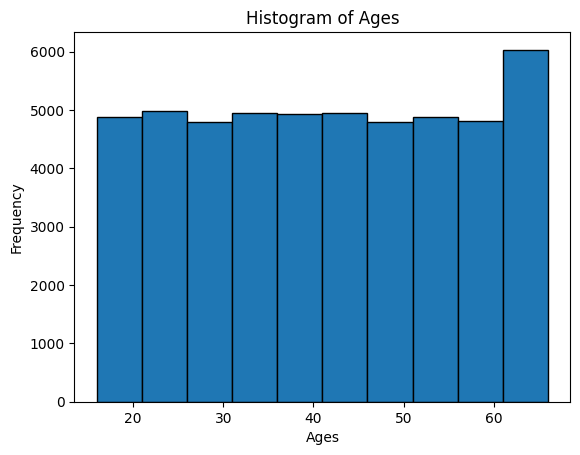

In [ ]:
%pip install matplotlib

import matplotlib.pyplot as plt

users_df = read_result["users"].to_pandas()

plt.hist(users_df["age"], bins=10, edgecolor="black")
plt.title("Histogram of Ages")
plt.xlabel("Ages")
plt.ylabel("Frequency")
plt.show()

## Working in SQL

Since data is cached in a local DuckDB database, we can query the data with SQL.

We can do this in multiple ways. One way is to use the [JupySQL Extension](https://jupysql.ploomber.io/en/latest/user-guide/template.html), which we'll use below.


In [ ]:
# Install JupySQL to enable SQL cell magics
%pip install --quiet jupysql
# Load JupySQL extension
%load_ext sql
# Configure max row limit (optional)
%config SqlMagic.displaylimit = 200

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 5.2 MB/s eta 0:00:00
Deploy Panel apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


In [ ]:
# Get the SQLAlchemy 'engine' object for the cache
engine = read_result.cache.get_sql_engine()
# Pass the engine to JupySQL
%sql engine

In [ ]:
# Get table objects for the 'users' and 'purchases' streams
users_table = read_result.cache["users"].to_sql_table()
purchases_table = read_result.cache["purchases"].to_sql_table()
display([users_table.fullname, purchases_table.fullname])

['main.users', 'main.purchases']

In [ ]:
%%sql
# Show most recent purchases by purchase date:
SELECT users.id, users.name, purchases.product_id, purchases.purchased_at
FROM {{ users_table.fullname }} AS users
JOIN {{ purchases_table.fullname }} AS purchases
ON users.id = purchases.user_id
ORDER BY purchases.purchased_at DESC
LIMIT 10

Running query in 'duckdb:///.cache/default_cache_db.duckdb'

id,name,product_id,purchased_at
21589,Torie,48,2024-12-10 20:32:08
39842,Kareen,45,2024-11-28 11:26:13
19248,Jerry,41,2024-11-05 00:59:42
30780,Dwana,82,2024-10-20 20:09:11
4669,Frankie,100,2024-10-15 16:23:02
42204,Lashaun,9,2024-10-06 08:06:59
13251,Charlie,46,2024-09-19 17:55:52
47798,Issac,40,2024-09-13 05:13:17
34970,Eleni,39,2024-09-13 00:15:55
24782,Jose,40,2024-09-08 09:49:06


In [ ]:
# Show tables for the other streams
%sqlcmd tables

Name
products
purchases
users
_PyAirbyte_state
_PyAirbyte_streams
